# Signal to Noise Ratio (SNR)

The signal to noise ratio (SNR) is a critical characteristic that impacts images quality.  For MRI, there is a strong theoretical foundation for the SNR dependency based on the MRI physics and pulse sequence characteristics.  

## Learning Goals

1. Understand the constraints and tradeoffs in MRI
    * Describe the factors that influence image SNR
1. Manipulate MRI sequence parameters to improve performance
    * Understand how modifications in sequence parameters will affect the expected SNR

## SNR Dependencies

The SNR in factors we control in an MRI experiment can be decomposed into dependencies on three factors:

1. Voxel volume
2. Data acquisition time
3. Transverse magnetization

There are other system factors that influence SNR such as the magnetic field strength and the RF coils.

### Voxel Volume

The MRI signal is an integral over a volume of the transverse magnetization.  Therefore there is a linear dependency on the MRI signal and the volume of magnetization being examined.  So we have

$$SNR \propto \mathrm{Voxel\ Volume} = \Delta x\ \Delta y\ \Delta z$$

### Data Acquisition Time

Every additional measurement allows for signal averaging since the noise varies at each measurement.  Note that MRI noise is zero-mean with a Gaussian distribution.  Additional data acquisition time increases signal linearly, while the total noise increases as the square root.  So

$$SNR \propto \frac{S}{\sigma} = \frac{T_{meas}}{\sqrt{T_{meas}}} = \sqrt{T_{meas}}$$

where $T_{meas}$ is the _total data acquisition/measurement time_ including all TRs and signal averaging, but not including the sequence downtime.

### Transverse Magnetization

The MRI signal is also proportional to the transverse magnetization, including modulation that occurs due to pulse sequence parameters such as TE, TR, flip angle, spin-echo versus gradient-echo, etc.  This is then also varying depending on the MR properties such as proton density, relaxation rates, diffusion coefficients, etc.  Since this varies widely by pulse sequence, we summarize this as

$$SNR \propto f_{seq}$$

For example, in a simple spoiled gradient-echo pulse sequence, 

$$f_{seq,GRE} = M_0 \sin(\theta) \frac{1- \exp(-TR/T_1)}{1- \cos(\theta) \exp(-TR/T_1)}$$

## SNR Equation

Putting it all together,

$$SNR \propto f_{seq}\ \mathrm{Voxel\ Volume}\ \sqrt{T_{meas}}$$

**This simple equation describes the majority of SNR effects in MRI, and is extremely powerful when designing and improving MRI scans!**

# SNR Efficiency

The SNR efficiency for MRI provides a measure of overall efficiency within a MRI scan, which is the SNR normalized by the *total scan time*, $T_{scan}$

$$SNR_{efficiency} = \frac{SNR}{\sqrt{T_{scan}}} \propto f_{seq}\ \mathrm{Voxel\ Volume}\ \sqrt{\frac{T_{meas} }{T_{scan}}}

## SNR efficiency versus TR

The SNR efficiency is useful to examine the choice of TR.  It is especially interesting for spoiled gradient-echo sequences where when we can choose to use the optimal flip angle ("Ernst angle") based on a $T_1$ value of interest.  For these sequences, the optimal flip angle is

$$\theta_{optimal} = \cos^{-1} \exp(-TR/T_1)$$

And $f_{seq,GRE}$ is defined above.

Under this condition, we see the following intriguing result ...

In [1]:
% setup MRI-education-resources path and requirements
cd ../
startup

loading image
loading signal


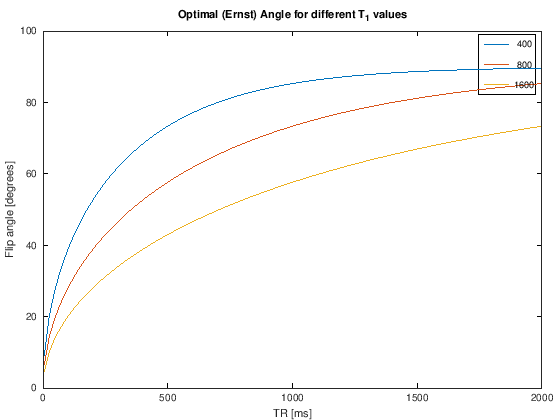

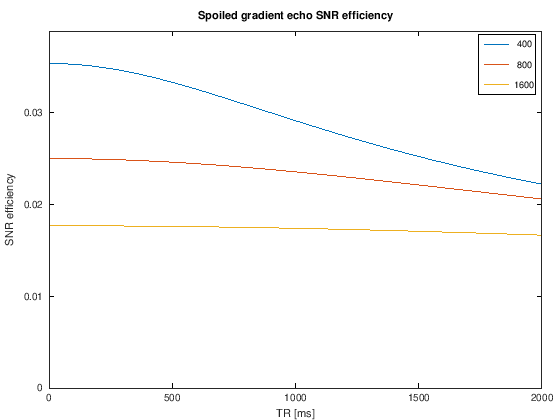

In [34]:
% SNR efficiency for spoiled gradient echo pulse sequences

TRdT1 = linspace(.01,4);
T1 = [400 800 1600];

% To remove TE or T2 effect
TE = 0; T2 = Inf;
M0 = 1;

theta_optimal = zeros(length(T1), length(TR));
SNR_efficiency = zeros(length(T1), length(TR));

for IT1 = 1:length(T1)

theta_optimal(IT1,:) = acos(exp(-TR/T1(IT1)));


SNR_efficiency(IT1,:) = MRsignal_spoiled_gradient_echo(theta_optimal(IT1,:), TE, TR, M0, T1(IT1), T2) ./ sqrt(TR);
end
%subplot(121)
plot(TR, theta_optimal*180/pi)
xlabel('TR [ms]'), ylabel('Flip angle [degrees]')
title('Optimal (Ernst) Angle for different T_1 values')
legend(int2str(T1.'))
%subplot(122)
figure
plot(TR, SNR_efficiency)
ylim([0 1.1*max(SNR_efficiency(:))])
legend(int2str(T1.'))
xlabel('TR [ms]'), ylabel('SNR efficiency')
title('Spoiled gradient echo SNR efficiency for different T_1 values')

Once the optimal flip angle begins to approach 90-degrees, the SNR efficiency begins to drop.  But for the shorter TRs, the SNR efficiency is relatively stable for different TRs.

## Resolution and SNR in Post-Processing

The image resolution is often changed in post-processing, and can be either upsampled to finer ("higher") spatial resolution or downsampled to coarser ("lower") spatial resolution.  When using the SNR equation above, the native resolution should be considered.

### Upsampling

Upsampling is typically done with some type of interpolation.  In MRI, this can be easily implemented in k-space through zero-padding, which is equivalent to sinc interpolation.  Upsampling with a reasonable method does not affect SNR.

### Downsampling

Downsampling is done to increase SNR by changing the image to a coarser resolution.  However, downsampling is effectively averaging signals from nearby voxels which also averages out the noise.  Therefore, downsampling scales SNR as the square root of the voxel size, similarly to the measurement time. 

This is a very important distinction from changed the acquired resolution, where the SNR scales linearly with voxel size.  Therefore, the SNR is higher when acquiring at the desired spatial resolution compared to acquiring at a finer resolution and then downsampling.  Care should be taken to choose the acquired resolution to match the desired resolution.


## SNR and $T_2^*$ decay

The SNR equation alone implies that the readout time should be as long as possible, as this leads to more total measurement time, but practically this is limited by the $T_2^*$ decay rate, since at some point there will no longer be any signal to measure.  To incorporate the effect of this decay, we need to account for the signal modulations during the readout by integrating the signal area, accounting for $T_2^*$, which will offset signal gains from extending the readout

$$SNR \propto \frac{ \int_0^{T_{read}} \exp(-\tau / T_2^*) d\tau } { \sqrt{T_{read}} }$$

$T_{read}$ is the readout duration, the numerator the signal acquired during this readout time, and the demoninator captures how the total noise scales with the square root of measurement time.  

The above equation applieds for a one-sided decay, as in a gradient echo, while the following applies in the case of two-sided T2* decay, as in a spin echo:
$$SNR \propto \frac{\int_{-T_{read}/2}^{T_{read}/2} | \exp(-\tau / T_2^*)  | d\tau }{\sqrt{T_{read}}}$$

Maximum for one-sided decay: T_{read} / T_2^* =1.2806
Maximum for two-sided decay: T_{read} / T_2^* =2.4907


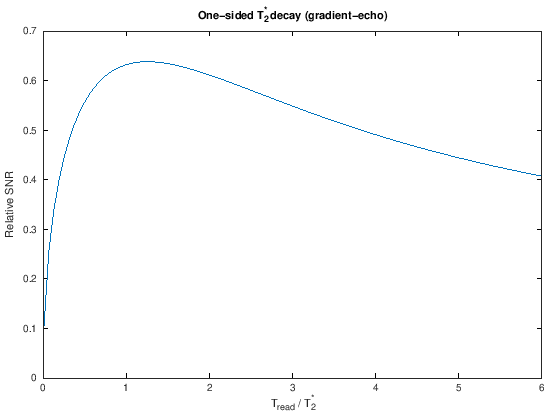

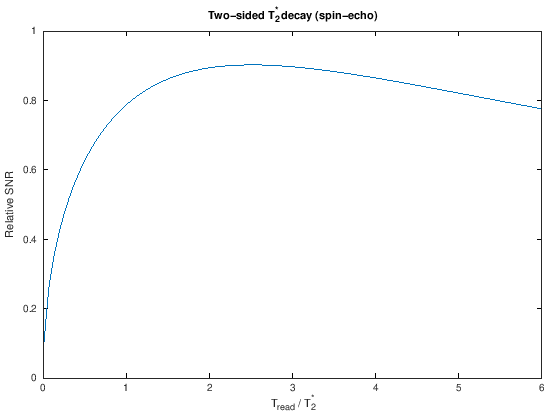

In [33]:
Tread = linspace(0.01, 6);
T2s = 1;

SNR_T2s_onesided = T2s * (1 - exp(-Tread/T2s)) ./ sqrt(Tread);
[~, Imax_onesided] = max(SNR_T2s_onesided);

SNR_T2s_twosided = T2s * 2 * (1 - exp(-Tread/2 / T2s)) ./ sqrt(Tread);
[~, Imax_twosided] = max(SNR_T2s_twosided);

plot(Tread, SNR_T2s_onesided)
xlabel('T_{read} / T_2^*')
ylabel('Relative SNR')
title('One-sided T_2^* decay (gradient-echo)');

disp(['Maximum for one-sided decay: T_{read} / T_2^* =' num2str(Tread(Imax_onesided))])

figure
plot(Tread, SNR_T2s_twosided)
xlabel('T_{read} / T_2^*')
ylabel('Relative SNR')
title('Two-sided T_2^* decay (spin-echo)');

disp(['Maximum for two-sided decay: T_{read} / T_2^* =' num2str(Tread(Imax_twosided))])


From this result, we can see that the optimal choice of $T_{read}$ from a SNR point of view is approximately $ T_{read} / T_2^* = 1.3$ (one-sided) and $ T_{read} / T_2^* = 2.5$ (two-sided).

However, this relationship does not take into account the effects of resolution loss that will typically occur due to decaying $T_2^*$ weighting in k-space.  (See "MRI Signal Equation" for information on this effect).